# pandas による時系列データ処理入門（その1）

- 本ノートブックで扱う内容
    - `pandas` を使った分析用データの生成方法
    - 特定データを抽出するための、条件式と適用方法

---

# 0. 前準備

- ライブラリのインポート

In [1]:
import numpy as np
import pandas as pd
#
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

---

# 1. 時系列データの生成

はじめに、時系列データをコード上で生成する方法から見ていこう。<br>
荒っぽいい言い方ではあるが <br>
「`pd.DataFrame`に詰められたデータに日付を付与」<br>
すれば、時系列データとみなすことができる。<br>
付与する日付は何でも良いが、ここでは連番で与えることにしよう。


## 1.1. 日付連番の作成方法

Q. 日付の連番を作成方法は？<br>
A. `pd.date_range` を使う

In [2]:
dates = pd.date_range(start='2022-1-1', end='2022-1-10', freq='D')
print(dates)
#freq=M と変更すると月末毎データに
months = pd.date_range(start='2022-1-1', end='2022-3-31', freq='M')
print(months)

DatetimeIndex(['2022-01-01', '2022-01-02', '2022-01-03', '2022-01-04',
               '2022-01-05', '2022-01-06', '2022-01-07', '2022-01-08',
               '2022-01-09', '2022-01-10'],
              dtype='datetime64[ns]', freq='D')
DatetimeIndex(['2022-01-31', '2022-02-28', '2022-03-31'], dtype='datetime64[ns]', freq='M')


## 1.2. 例題用データの作成

では、適当な `pd.DataFrame` を作って日付を付与してみよう。

まず、適当なデータを作る、<br>
ここでは、別資料 `graph.ipynb` で使ったsinカーブのデータを使おう。

In [3]:
# 空のDataFrameを作成
df_sin = pd.DataFrame()
# x軸の値を新規設定
df_sin['x'] = np.linspace(-np.pi-0.5, np.pi+0.5, 51)
# y軸の値を設定
df_sin['sin(x)'] = np.sin(df_sin['x'])
df_sin['cos(x)'] = np.cos(df_sin['x'])
#
print(df_sin.head())

          x    sin(x)    cos(x)
0 -3.641593  0.479426 -0.877583
1 -3.495929  0.346968 -0.937877
2 -3.350265  0.207161 -0.978307
3 -3.204602  0.062967 -0.998016
4 -3.058938 -0.082561 -0.996586


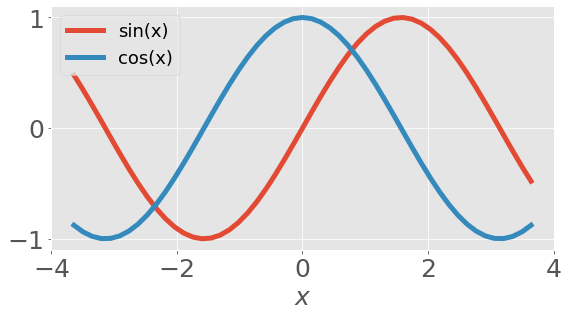

In [4]:
# 描画キャンバスを準備
fig, ax = plt.subplots(ncols=1, nrows=1, sharex='all', figsize=(16*0.5, 9*0.5))
#
df_sin.plot.line(ax=ax, x='x', y='sin(x)', linewidth=5)
df_sin.plot.line(ax=ax, x='x', y='cos(x)', linewidth=5)
#　ラベルを付ける
plt.xlabel("$x$", fontsize=25)
plt.ylabel("", fontsize=25)
# 文字サイズ調整
plt.legend(fontsize=18)
plt.tick_params(labelsize=25)
# 余白の削除 (地味に便利)
plt.tight_layout()
# ノートブック上でのグラフ確認
plt.show()
plt.close()

`df_sin` のインデックスを　`pd.date_range` で生成した日付データに変更しよう。

In [5]:
#　51個のデータが入っているので、期間ではなく periods で個数指定する。
months = pd.date_range(start='2018-1-1', periods=51, freq='M')
# インデックスを日付に設定
df_sin.index = months
print(df_sin.head())

                   x    sin(x)    cos(x)
2018-01-31 -3.641593  0.479426 -0.877583
2018-02-28 -3.495929  0.346968 -0.937877
2018-03-31 -3.350265  0.207161 -0.978307
2018-04-30 -3.204602  0.062967 -0.998016
2018-05-31 -3.058938 -0.082561 -0.996586


グラフのx軸を日付に変更するには以下の通り。

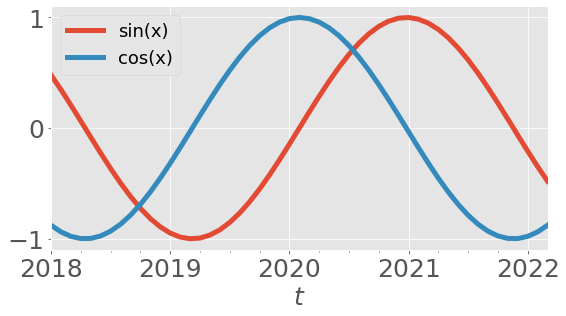

In [16]:
# 描画キャンバスを準備
fig, ax = plt.subplots(ncols=1, nrows=1, sharex='all', figsize=(16*0.5, 9*0.5))
#
# df_sin.plot.line(ax=ax, x='x', y='sin(x)', linewidth=5)
df_sin.plot.line(ax=ax, y='sin(x)', linewidth=5) # x軸に列名指定がないとインデックスが使われる
df_sin.plot.line(ax=ax, y='cos(x)', linewidth=5)
#　ラベルを付ける
plt.xlabel("$t$", fontsize=25)
plt.ylabel("", fontsize=25)
# 文字サイズ調整
plt.legend(fontsize=18)
plt.tick_params(labelsize=25)
# 余白の削除 (地味に便利)
plt.tight_layout()
# ノートブック上でのグラフ確認
plt.show()
plt.close()

---

# 2. 特定期間データの取り出し

`pd.DataFrame` から特定データを取り出す際に<br>
初心者が真っ先にやりがちな方法は `.iloc` を使って列番号を指定する方法です。<br>
（あくまで、これを書いてる人間の経験をもとにした主観です。）<br>
しかし、この方法は以下の点でイマイチよろしくない。

- データフレームの中身が変わると全部台無し
- `.iloc`で指定した番号と日付が結びつきづらい

必要なデータを取り出す際には<br>
__「条件式」を人間にも分かりやすい形で指定する__<br>
とバグも減り、可読性も高まる。<br>
では、上で作った `df_sin` を例に説明しよう。

## 2.1. `df_sin['x']`の絞り込み

いきなり日付指定を考えると分かりづらいので<br>
まずは `df_sin['x']` についての条件式から考える。<br>
$x < -\dfrac{\pi}{2}$ の範囲に絞り込みたいとする。<br>
思いつく条件式は、`df_sin['x']< -1.57` だろう。<br>
この条件式で以下のように書くとうまくデータが抽出できる。

In [7]:
df_sin[df_sin['x'] < -1.57]

,x,sin(x),cos(x)
2018-01-31,-3.641593,0.479426,-0.877583
2018-02-28,-3.495929,0.346968,-0.937877
2018-03-31,-3.350265,0.207161,-0.978307
2018-04-30,-3.204602,0.062967,-0.998016
2018-05-31,-3.058938,-0.082561,-0.996586
2018-06-30,-2.913274,-0.226340,-0.974048
2018-07-31,-2.767610,-0.365325,-0.930880
2018-08-31,-2.621947,-0.496573,-0.867995
2018-09-30,-2.476283,-0.617303,-0.786726
2018-10-31,-2.330619,-0.724958,-0.688793


何故これでうまくいくのかは `df_sin['x'] < -1.57` を実行してみると良い。<br>
これは、各行の`x`が条件を満たしているかをブール値で返している。<br>
上記のセルのコードは　`df_sin` の行のうち `TRUE` のものだけが絞り込まれている。<br>
（出力すると長くなるので、コメントアウトしておく。）

In [8]:
# df_sin['x'] < -1.57

次は $-\dfrac{\pi}{4} < x < \dfrac{\pi}{4}$ の範囲に絞り込みたいとする。<br>
条件式は　`df_sin[x]> -0.79` と `df_sin[x] < 0.79` の２つである。<br>
２つの条件を組み合わせるには、以下のようにする：

In [9]:
df_sin[(df_sin['x'] > -0.79) & (df_sin['x'] < 0.79)]

,x,sin(x),cos(x)
2019-09-30,-0.728319,-0.665616,0.746295
2019-10-31,-0.582655,-0.550243,0.835005
2019-11-30,-0.436991,-0.423215,0.906029
2019-12-31,-0.291327,-0.287224,0.957863
2020-01-31,-0.145664,-0.145149,0.989410
2020-02-29,0.000000,0.000000,1.000000
2020-03-31,0.145664,0.145149,0.989410
2020-04-30,0.291327,0.287224,0.957863
2020-05-31,0.436991,0.423215,0.906029
2020-06-30,0.582655,0.550243,0.835005


条件式の組み合わせ方法など、より詳細については

- [pandasで複数条件のAND, OR, NOTから行を抽出（選択）](https://note.nkmk.me/python-pandas-multiple-conditions/)
- [pandas.DataFrameの行を条件で抽出するquery](https://note.nkmk.me/python-pandas-query/)

などを参照するとよい。<br>
特に下段の `.query()` を使う方法はコードがキレイに書けるのでおすすめ。<br>
上記のコードをqueryで書き直すと
```
df_sin.query('(x > - 0.79) & (x < 0.79)')
```
である。
ただし、慣れない内は無理に使う必要はない。

## 2.2. `df_sin`の日付での絞り込み

`print(df_sin)` としてみれば分かるが日付に相当する列名が存在しない。<br>
つまり、`df_sin['t']`などの列名指定で処理をすることができない。

今回のケースでは日付を`pd.DataFrame`のインデックスにしていることが原因である。<br>
これは別に大きな問題ではなく、`df_sin['x']`を`df_sin.index`に変えればよいだけである。<br>

`df_sin`の内、2020年のデータだけがほしいならば<br>
例えば次のようにする：

In [10]:
df_sin[(df_sin.index >= "2020-1-1") & (df_sin.index < "2021-1-1")]

# .queryを使うなら以下の通り
# df_sin.query('(index >= "2020-1-1") & (index < "2021-1-1")')

,x,sin(x),cos(x)
2020-01-31,-0.145664,-0.145149,0.989410
2020-02-29,0.000000,0.000000,1.000000
2020-03-31,0.145664,0.145149,0.989410
2020-04-30,0.291327,0.287224,0.957863
2020-05-31,0.436991,0.423215,0.906029
2020-06-30,0.582655,0.550243,0.835005
2020-07-31,0.728319,0.665616,0.746295
2020-08-31,0.873982,0.766891,0.641778
2020-09-30,1.019646,0.851923,0.523668
2020-10-31,1.165310,0.918911,0.394466


上では 「2020年1月1日以降、2021年1月1日未満」 を条件式にしたが<br>
今回の要件を満たす条件式は複数存在するので、自由に思いついたものを使えばよい。

ただし、経験上<br>
「2020年1月1日以降、2021年12月31日以前」<br>
のように月末日を指定する条件式は、あまりおすすめできない。<br>
というのも、月末日は28日~31日の間で月ごとに変化するためである。<br>
12月の月末日が31日なのは迷わないだろうが<br>
5月の月末日が30日なのか31日なのか即答できます？

さて、実際には絞り込む期間を複数パターン変更して分析することが多い。<br>
その場合には、開始日と終了日を変数として準備しておくと分かりやすくなる：

In [11]:
from_date = '2020-1-1'
to_date = '2021-1-1'
df = df_sin[(df_sin.index >= from_date) & (df_sin.index < to_date)]

では、次に例題を解いてみよう。

Q. <br>
`df_sin` を、 2018年・2019年・2020年　のそれぞれのデータに分けて表示しなさい、<br>
ただし、`for` を使った繰り返し処理で実装すること。

A. <br>
上記の2020年の部分を変数にすれば良い

In [12]:
for y in [2018,2019, 2020]:
    from_date = str(y) + '-1-1' # yは数値なので文字列とは結合できない。そこでstr(y)にして文字列に変換。
    to_date = str(y+1) + '-1-1' 
    df = df_sin[(df_sin.index >= from_date) & (df_sin.index < to_date)]
    print(df.head(3)) #スペースを食うので先頭３行のみに表示制限
    # print(df) #本当の正解コードはこっち

                   x    sin(x)    cos(x)
2018-01-31 -3.641593  0.479426 -0.877583
2018-02-28 -3.495929  0.346968 -0.937877
2018-03-31 -3.350265  0.207161 -0.978307
                   x    sin(x)    cos(x)
2019-01-31 -1.893628 -0.948341 -0.317253
2019-02-28 -1.747964 -0.984347 -0.176243
2019-03-31 -1.602301 -0.999504 -0.031499
                   x    sin(x)   cos(x)
2020-01-31 -0.145664 -0.145149  0.98941
2020-02-29  0.000000  0.000000  1.00000
2020-03-31  0.145664  0.145149  0.98941


なお、分割したデータフレームを保存したいなら<br>
空のリストを作って、要素に追加していく方法などがある。<br>
（これも幾らでもやり方があって、自由にすればOK）

In [13]:
# 結果の入れ物を準備 : 空のリストを使う。
results = []
#
for y in [2018,2019, 2020]:
    from_date = str(y) + '-1-1'
    to_date = str(y+1) + '-1-1' 
    df = df_sin[(df_sin.index >= from_date) & (df_sin.index < to_date)]
    results.append(df) # リストへの要素追加
    # results += [df] #　簡単に書くならこっちでもOK
#
print(results[1].tail(3)) #例えば 2019年のデータを表示

                   x    sin(x)    cos(x)
2019-10-31 -0.582655 -0.550243  0.835005
2019-11-30 -0.436991 -0.423215  0.906029
2019-12-31 -0.291327 -0.287224  0.957863


In [14]:
df = df_sin.query('index < "2021-1-1"')
df = df.tail(6)
print(df)

                   x    sin(x)    cos(x)
2020-07-31  0.728319  0.665616  0.746295
2020-08-31  0.873982  0.766891  0.641778
2020-09-30  1.019646  0.851923  0.523668
2020-10-31  1.165310  0.918911  0.394466
2020-11-30  1.310973  0.966435  0.256909
2020-12-31  1.456637  0.993491  0.113911
